<a href="https://colab.research.google.com/github/LJThao/atlas-machine_learning/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/data/bitstamp.csv.zip

Archive:  /content/data/bitstamp.csv.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv  


In [ ]:
!unzip /content/data/coinbase.csv.zip

Archive:  /content/data/coinbase.csv.zip
  inflating: coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv  


Preprocessing the data

In [ ]:
#!/usr/bin/env python3
"""Preprocessing Data Module"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def preprocess(file='/content/coinbase.csv', window_size=24):
    df = pd.read_csv(file)

    print("Columns in CSV:", df.columns.tolist())

    if 'Close' in df.columns:
        df = df[['Close']]
    elif 'close' in df.columns:
        df = df[['close']]
    else:
        raise ValueError("Close column is not found in the CSV.")

    df = df.dropna()

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled) - window_size):
        X.append(scaled[i:i + window_size])
        y.append(scaled[i + window_size])

    np.save('X.npy', np.array(X))
    np.save('y.npy', np.array(y))
    np.save('scaler.npy', scaler)

if __name__ == '__main__':
    preprocess()

Columns in CSV: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']


Creates, Trains, and Validates A Keras Model for the forecasting of BTC:

In [ ]:
#!/usr/bin/env python3
"""Forecast Module"""
import numpy as np
import tensorflow as tf


X = np.load('X.npy')
y = np.load('y.npy')

dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X.shape[1:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(dataset, epochs=10)

model.save('btc_forecast_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - loss: 3.6318e-07
Epoch 2/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 113s 4ms/step - loss: 1.7777e-07
Epoch 3/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 114s 4ms/step - loss: 1.2992e-07
Epoch 4/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 115s 4ms/step - loss: 1.2597e-07
Epoch 5/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - loss: 1.3040e-07
Epoch 6/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - loss: 1.2248e-07
Epoch 7/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 115s 4ms/step - loss: 1.2127e-07
Epoch 8/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 115s 4ms/step - loss: 1.2216e-07
Epoch 9/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - loss: 1.2484e-07
Epoch 10/10
31105/31105 ━━━━━━━━━━━━━━━━━━━━ 115s 4ms/step - loss: 1.2148e-07


Validating by split up the data and retraining the model with validation tracking.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(tf.data.AUTOTUNE)


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 105s 4ms/step - loss: 4.5358e-07 - val_loss: 7.3425e-04
Epoch 2/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 105s 4ms/step - loss: 2.1880e-05 - val_loss: 0.0012
Epoch 3/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 110s 4ms/step - loss: 4.5453e-05 - val_loss: 0.0012
Epoch 4/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 5.1951e-05 - val_loss: 8.6452e-04
Epoch 5/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 109s 4ms/step - loss: 3.5853e-05 - val_loss: 5.4206e-04
Epoch 6/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 109s 4ms/step - loss: 2.1432e-05 - val_loss: 2.1522e-04
Epoch 7/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 7.6019e-06 - val_loss: 1.4118e-04
Epoch 8/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 4.7705e-06 - val_loss: 1.2111e-04
Epoch 9/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 4.0351e-06 - val_loss: 1.1076e-04
Epoch 10/10
24884/24884 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 3.6541e-06 - val_loss: 1.0104e-04


Predicting and Ploting the Actual vs the Predicted BTC Prices

12442/12442 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


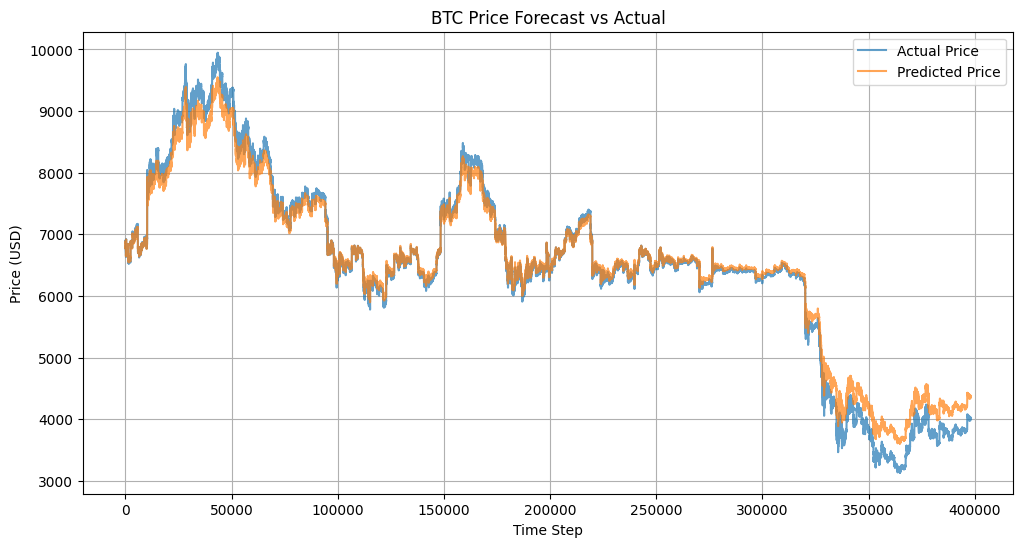

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

y_pred = model.predict(X_val)

scaler = np.load('scaler.npy', allow_pickle=True).item()

y_pred_inv = scaler.inverse_transform(y_pred)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual Price', alpha=0.7)
plt.plot(y_pred_inv, label='Predicted Price', alpha=0.7)
plt.title('BTC Price Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('/content/btc_model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/time_series/btc_model.h5')

np.save('/content/drive/MyDrive/time_series/X.npy', X)
np.save('/content/drive/MyDrive/time_series/y.npy', y)
np.save('/content/drive/MyDrive/time_series/scaler.npy', scaler)

In [ ]:
!cp coinbase.csv /content/drive/MyDrive/time_series/coinbase.csv
!cp bitstamp.csv /content/drive/MyDrive/time_series/bitstamp.csv
!cp btc_forecast_model.h5 /content/drive/MyDrive/time_series/btc_forecast_model.h5



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cd /content/drive/MyDrive/time_series/

Visualizing the Model Forecasts: True vs Predicted BTC Close Price after 24 hours

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast_windows(X_sample, y_true, y_pred, num_windows=4):
    """Plots input windows with true vs predicted labels"""
    plt.figure(figsize=(10, num_windows * 2.5))

    for i in range(num_windows):
        plt.subplot(num_windows, 1, i + 1)

        # plot input window (24 hours)
        plt.plot(range(X_sample.shape[1]), X_sample[i].squeeze(), label='Inputs')

        # plot true label (next hour)
        plt.scatter(X_sample.shape[1], y_true[i], color='green', label='Label')

        # plot predicted label (next hour)
        plt.scatter(X_sample.shape[1], y_pred[i], color='orange', marker='x', label='Prediction')

        plt.xlabel("Time [h]")
        plt.ylabel("Close [normed]")
        if i == 0:
            plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/time_series/btc_model.h5', compile=False)

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
import numpy as np

X = np.load('/content/drive/MyDrive/time_series/X.npy')
y = np.load('/content/drive/MyDrive/time_series/y.npy')


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

12442/12442 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


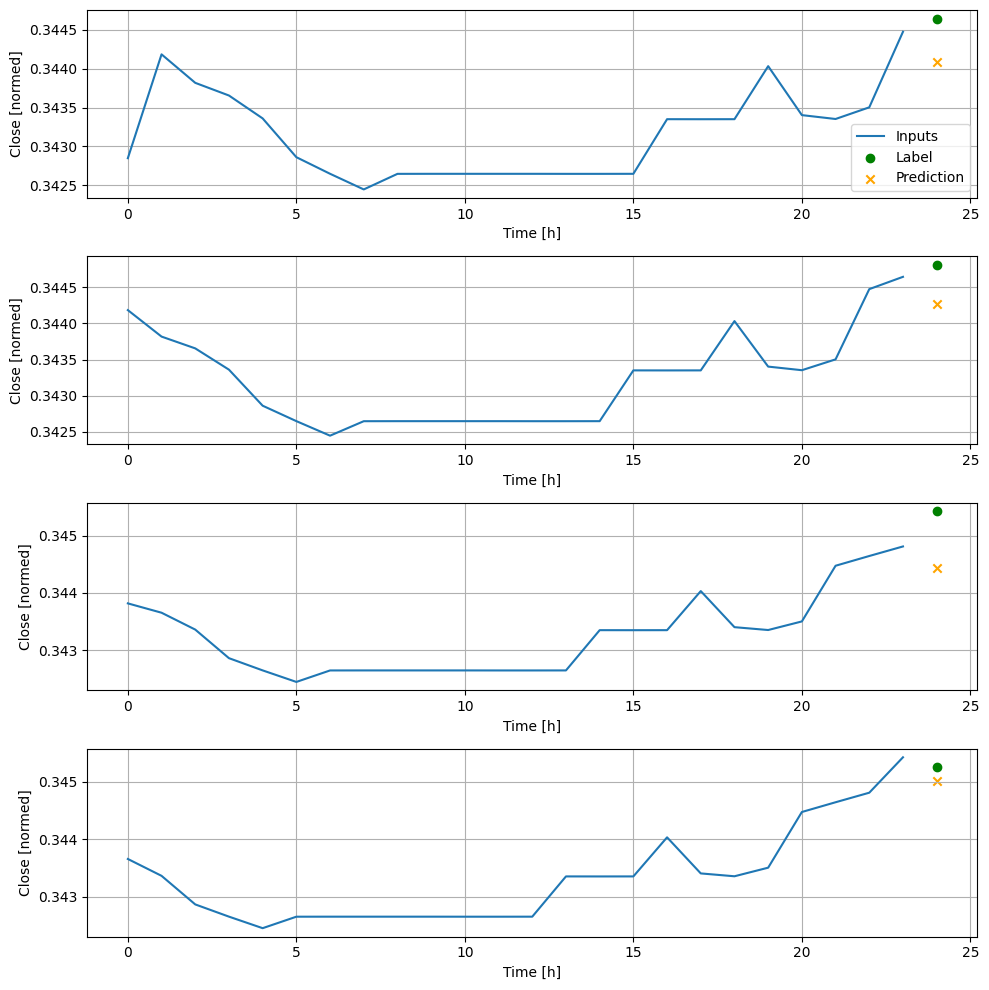

In [ ]:
y_pred = model.predict(X_val)
plot_forecast_windows(X_val, y_val, y_pred, num_windows=4)


Validation and Forecasting

In [ ]:
import numpy as np

X = np.load('/content/drive/MyDrive/time_series/X.npy')
y = np.load('/content/drive/MyDrive/time_series/y.npy')

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

12442/12442 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


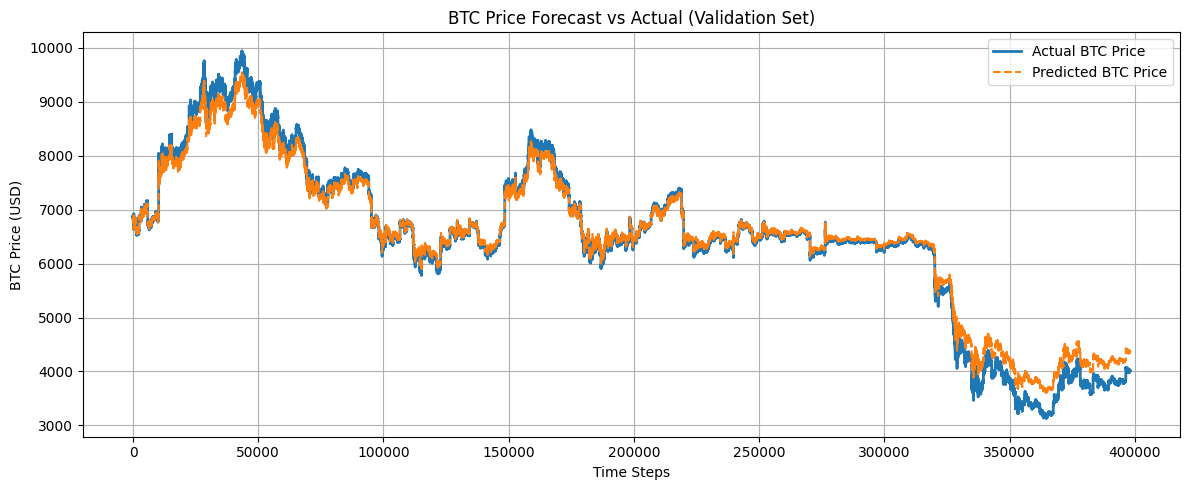

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


scaler = np.load('/content/drive/MyDrive/time_series/scaler.npy', allow_pickle=True).item()

y_pred = model.predict(X_val)

y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12, 5))
plt.plot(y_val_actual, label='Actual BTC Price', linewidth=2)
plt.plot(y_pred_actual, label='Predicted BTC Price', linestyle='--')
plt.title('BTC Price Forecast vs Actual (Validation Set)')
plt.xlabel('Time Steps')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()